In [1]:
import numpy as np 
import torch
from torch import nn
import pandas as pd

from matplotlib import pyplot as plt

In [ ]:
data =  pd.read_csv("navigation_data_multiple_episodes.csv")

In [ ]:
data.head()

In [4]:
data['World_Theta_new'] =  (data['World_Theta'] + np.pi) % (2 * np.pi) - np.pi

In [ ]:
(315+180)%360 - 180

In [4]:
data['World_Theta_new'] = np.where((data['World_Theta'] > np.pi) | (data['World_Theta'] < 0),
                                   -(np.pi - data['World_Theta'] % np.pi),
                                   data['World_Theta'])

In [ ]:
np.rad2deg(data['World_Theta_new']).describe().astype(str)

In [6]:
# 
# # target = ['L', 'Theta']

# # Calculate ground truth midpoints for the chunk
# data['Midpoint_x'] = (data['Bot_x'] + data['Goal_x']) / 2
# data['Midpoint_y'] = (data['Bot_y'] + data['Goal_y']) / 2

In [62]:
L_max = 1.0  # Maximum distance
Theta_max = np.pi / 9  # Maximum angular deviation (20 degrees)

# Function to compute ground truth (L, Theta)
def compute_ground_truth(row):
    # Vector to the goal
    dx = row['Goal_x'] - row['Bot_x']
    dy = row['Goal_y'] - row['Bot_y']
    distance_to_goal = np.sqrt(dx**2 + dy**2)
    
    # Angle to the goal in global frame
    theta_to_goal = np.arctan2(dy, dx)

    theta_to_goal = (theta_to_goal + np.pi) % (2 * np.pi) - np.pi
    
    # Relative angle (Theta) with respect to the bot's current orientation
    relative_theta = theta_to_goal - row['World_Theta_new']
    
    # Normalize relative_theta to [-pi, pi] for proper angle calculation
    relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi
    
    # Determine the sign of L: positive if goal is in the forward-facing hemisphere of the bot
    if relative_theta <0:  # Goal is behind the bot, turn
        L = 0
    else:  # Goal is in front of the bot
        L = min(distance_to_goal, L_max)
    
    # Clip Theta to [-Theta_max, Theta_max]
    Theta = np.clip(relative_theta, -Theta_max, Theta_max)
    
    return pd.Series([L, Theta], index=['L', 'Theta'])

In [ ]:
np.sin(np.pi/9)

In [64]:
data[['Target_L', 'Target_theta']] = data.apply(compute_ground_truth, axis=1)

In [ ]:
data['Target_L'].value_counts()

In [ ]:
np.rad2deg(data['Relative_Theta']).describe().astype(str)

In [ ]:
data[['Target_theta', 'Relative_Theta']].head()

In [131]:
data['turn_angle'] = data['World_Theta'] + data['Predicted_Theta']
data['Target_x'] = data['Bot_x'] + data['Predicted_L'] * np.cos(data['turn_angle'])
data['Target_y'] = data['Bot_y'] + data['Predicted_L'] * np.sin(data['turn_angle'])

In [ ]:
plt.figure(figsize=(10, 8))
for episode in data['Episode'].unique()[20000:20001]:  # Limit to 5 episodes for clarity
    episode_data = data[data['Episode'] == episode]
    plt.scatter(episode_data['Bot_x'], episode_data['Bot_y'], label=f'Episode {episode}')
    # plt.scatter(episode_data['Midpoint_x'], episode_data['Midpoint_y'], color='green', label=f'mid {episode}')
    # plt.scatter(episode_data['Target_x'], episode_data['Target_y'], color='cyan', label=f'mid {episode}')
    plt.scatter(episode_data['Goal_x'].iloc[-1], episode_data['Goal_y'].iloc[-1], color='green', s=50, label=f'Goal {episode}')
    
    # print(episode_data['Prev_Chunk_x'], episode_data['Prev_Chunk_y'])
    # plt.scatter(episode_data['Current_Chunk_x'], episode_data['Current_Chunk_y'], color='red', s=30, label=f'curr Chunk {episode}')
    # plt.scatter(episode_data['Next_Chunk_x'], episode_data['Next_Chunk_y'], color='purple', s=30, label=f'next Chunk {episode}')
    # plt.scatter(episode_data['Prev_Chunk_x'], episode_data['Prev_Chunk_y'], color='yellow', s=10, label=f'prev Chunk {episode}')

plt.title('Robot Trajectory vs. Goal and Chunks')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

for episode in data['Episode'].unique()[2024:2025]:  # Limit to 5 episodes for clarity
    episode_data = data[data['Episode'] == episode]
    
    # Plot the trajectory points
    plt.scatter(episode_data['Bot_x'], episode_data['Bot_y'], label=f'Episode {episode}')
    plt.scatter(episode_data['Target_x'], episode_data['Target_y'], color='cyan', label=f'target {episode}')
    plt.scatter(episode_data['Goal_x'].iloc[-1], episode_data['Goal_y'].iloc[-1], color='green', s=50, label=f'Goal {episode}')
    
    # Add direction arrows for bot (based on World_Theta_new)
    dx_bot = np.cos(episode_data['World_Theta_new'].values)  # x-direction of bot's orientation
    dy_bot = np.sin(episode_data['World_Theta_new'].values)  # y-direction of bot's orientation
    
    # Plot the arrows indicating the bot's orientation
    for i in range(0, len(dx_bot), 2):
        plt.quiver(
            episode_data['Bot_x'].iloc[i], episode_data['Bot_y'].iloc[i],  # Starting point
            dx_bot[i], dy_bot[i],  # Direction from World_Theta_new
            angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.7, width=0.005
        )
    
    # Add direction arrows for target (based on target's angle to goal)
    # dx_target = np.cos(np.arctan2(episode_data['Goal_y'] - episode_data['Target_y'], episode_data['Goal_x'] - episode_data['Target_x']))
    # dy_target = np.sin(np.arctan2(episode_data['Goal_y'] - episode_data['Target_y'], episode_data['Goal_x'] - episode_data['Target_x']))
    dx_target = np.cos(episode_data['turn_angle'].values)  # x-direction of bot's orientation
    dy_target = np.sin(episode_data['turn_angle'].values)  # y-direction of bot's orientation
    
    # Plot the arrows indicating the target's direction
    for i in range(0, len(dx_target), 2):
        plt.quiver(
            episode_data['Bot_x'].iloc[i], episode_data['Bot_y'].iloc[i],  # Starting point
            dx_target[i], dy_target[i],  # Direction based on target's angle to goal
            angles='xy', scale_units='xy', scale=1, color='red', alpha=0.7, width=0.005
        )

plt.title('Robot Trajectory vs. Goal and Chunks')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()


In [151]:
features = ['Bot_x', 'Bot_y', 'Goal_x', 'Goal_y', 'World_Theta']

X = data[features].values
y = data[['Predicted_L', 'Predicted_Theta']].values


#Normalization
extent_feat = np.array([20, 14, 20, 14, 2*np.pi])

extent_tgt = np.array([1, 2*np.pi])

X = X/extent_feat
y = y/extent_tgt

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [154]:
import pytorch_lightning as pl
import torch.nn.functional as F

class NavigationModel(pl.LightningModule):
    def __init__(self, input_dim, lr=0.001):
        super(NavigationModel, self).__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Output: [L, Theta]
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)

        turn_angle_pred = x[:, 4] + predictions[:, 1]

        # Compute predicted position
        # pred_x = x[:, 0] + predictions[:, 0] * torch.cos((turn_angle_pred)*2*np.pi)
        # pred_y = x[:, 1] + predictions[:, 0] * torch.sin((turn_angle_pred)*2*np.pi)

        # turn_angle_gt = x[:, 4] + y[:, 1]

        # # Ground truth positions
        # true_x = x[:, 0] + y[:, 0] * torch.cos((turn_angle_gt)*2*np.pi)
        # true_y = x[:, 1] + y[:, 0] * torch.sin((turn_angle_gt)*2*np.pi)

        # Compute loss
        # loss = (self.criterion(pred_x, true_x) + self.criterion(pred_y, true_y))
        angle_loss = self.criterion(predictions, y)
        l_loss = self.criterion(predictions, y)
        loss = l_loss+ angle_loss
        self.log('train_loss', loss, prog_bar=True)
        self.log("train_l_loss", l_loss)
        self.log("train_angle_loss", np.rad2deg(angle_loss.item()*np.pi*2))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)

        #goal positin
        # goal_x = x[:, 2]
        # goal_y = x[:, 3]

        # turn_angle_pred = x[:, 4] + predictions[:, 1]

        # # Compute predicted position
        # pred_x = x[:, 0] + predictions[:, 0] * torch.cos((turn_angle_pred)*2*np.pi)
        # pred_y = x[:, 1] + predictions[:, 0] * torch.sin((turn_angle_pred)*2*np.pi)

        # turn_angle_gt = x[:, 4] + y[:, 1]

        # # Ground truth positions
        # true_x = x[:, 0] + y[:, 0] * torch.cos((turn_angle_gt)*2*np.pi)
        # true_y = x[:, 1] + y[:, 0] * torch.sin((turn_angle_gt)*2*np.pi)


        # # Compute loss
        # loss = self.criterion(pred_x, true_x) + self.criterion(pred_y, true_y)
        angle_loss = self.criterion(predictions, y)
        l_loss = self.criterion(predictions, y)
        loss = l_loss+ angle_loss
        self.log('val_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [155]:
from torch.utils.data import DataLoader, TensorDataset

# Create PyTorch Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [ ]:
from pytorch_lightning import Trainer

# Initialize the model
input_dim = len(features)
model = NavigationModel(input_dim)

# Initialize the trainer
trainer = Trainer(max_epochs=3, log_every_n_steps=50)

# Train the model
trainer.fit(model, train_loader, val_loader)

1 0.6599999956466576 cc 0 0 to -0.65418826 0.08739402 ori 172.39082113503838
current ori : 0.0, predicted ori: 172.39082113503838
2 4.0245584642661925e-16 cc -0.65418826 0.0873940200000004 to -0.65418826 0.08739402 ori -90.0
current ori : 172.39082113503838, predicted ori: 97.6091788649616
2 1.2888816243442802 cc -0.65418826 0.08739402 to -0.49868738 1.36686083 ori 83.07050297164538
current ori : -90.0, predicted ori: 173.0705029716454
2 0.2888816243442803 cc -0.5335403455112575 1.080089381492899 to -0.49868738 1.36686083 ori 83.07050297164544
current ori : 83.07050297164538, predicted ori: 5.088887490341627e-14
3 0.0 cc -0.49868738 1.36686083 to -0.49868738 1.36686083 ori 0.0
current ori : 83.07050297164544, predicted ori: -83.07050297164544
3 2.967873506948365 cc -0.49868738 1.36686083 to 1.95564562 3.03554974 ori 34.21159090044354
current ori : 0.0, predicted ori: 34.21159090044354
3 1.967873506948365 cc 0.3282794682345803 1.9291115142334339 to 1.95564562 3.03554974 ori 34.211590900

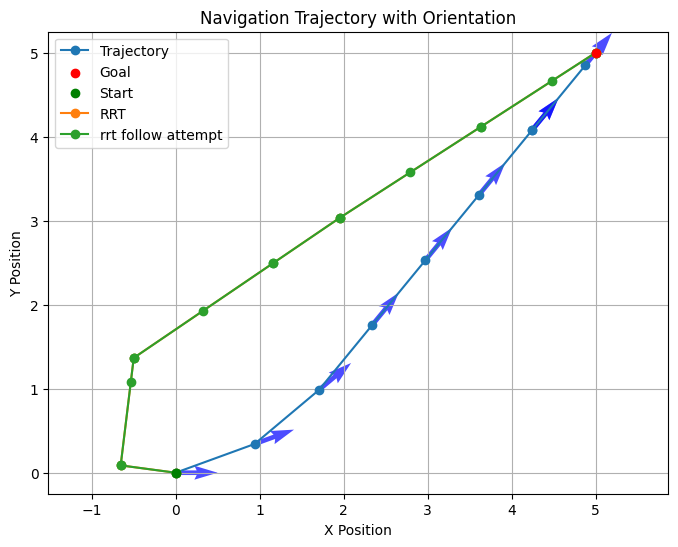

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def navigate_and_plot(model, initial_bot_position, goal_position, max_steps=100, L_max=1.0):
    # Initialize position, orientation, and trajectory
    bot_x, bot_y = initial_bot_position
    goal_x, goal_y = goal_position
    trajectory = [(bot_x, bot_y)]
    orientations = [0]  # Initial orientation (world_theta)


    trajectory_r = [(bot_x, bot_y)]
    orientations_r = [0]  # Initial orientation (world_theta)
    
    rrt_path = np.array([[ 0., 0.        ],
                    [-0.65418826 , 0.08739402],
                    # [-0.65418826 , 0.08739402],
                    # [-0.71786134  ,0.74431543],
                    # [-0.71786134  ,0.74431543],
                    [-0.49868738  ,1.36686083],
                    # [-0.49868738  ,1.36686083],
                    # [ 0.72847912  ,2.20120528],
                    [ 1.95564562  ,3.03554974],
                    # [ 3.18281212  ,3.8698942 ],
                    # [ 4.40997862  ,4.70423866],
                    # [ 4.40997862  ,4.70423866],
                    [ 5.          ,5.        ]])

    
    # rrt follwing
    idx = 1
    
    while idx < len(rrt_path):
        wp_x, wp_y = rrt_path[idx][0], rrt_path[idx][1]

        dx = wp_x - bot_x
        dy = wp_y - bot_y
        distance_to_goal = np.sqrt(dx**2 + dy**2)

        relative_theta = np.arctan2(dy, dx)
        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]
        
        predicted_theta = relative_theta - orientations_r[-1]
        predicted_theta = (predicted_theta + np.pi) % (2 * np.pi) - np.pi

        predicted_L = min(distance_to_goal, 1) if predicted_theta>=0 else 0.
        # predicted_L = min(1, distance_to_goal)

        # predicted_theta = np.clip(predicted_theta, -np.pi/9, np.pi/9)

        # print(f'current ori : {np.rad2deg(orientations[-1])}, predicted ori: {np.rad2deg(predicted_theta)}')

        new_orientation = orientations_r[-1] + predicted_theta
        new_orientation = (new_orientation + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        if distance_to_goal <0.1:
            idx +=1

        print(idx, distance_to_goal, "cc" , bot_x, bot_y, "to", wp_x, wp_y, "ori", np.rad2deg(new_orientation))
        print(f'current ori : {np.rad2deg(orientations_r[-1])}, predicted ori: {np.rad2deg(predicted_theta)}')

        # Update bot position
        bot_x += predicted_L * np.cos(new_orientation)
        bot_y += predicted_L * np.sin(new_orientation)

        # print(f'current: ({bot_x}, {bot_y}), goal: {goal_x}, {goal_y}')

        # Save trajectory and orientation
        trajectory_r.append((bot_x, bot_y))
        orientations_r.append(new_orientation)

        # # Check if the bot is near the goal
        # if distance_to_goal < 0.5:  # Threshold for goal proximity
        #     print(f"Goal reached in {step+1} steps!")
        #     break

    bot_x, bot_y = (0, 0)
    # Start navigation
    for step in range(max_steps):
        # Compute relative theta and other features
        dx = goal_x - bot_x
        dy = goal_y - bot_y
        distance_to_goal = np.sqrt(dx**2 + dy**2)

        if distance_to_goal <0.5:
            break

        relative_theta = np.arctan2(dy, dx)
        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        # Input features for the model
        input_features = torch.tensor([[bot_x/20.0, bot_y/14.0, goal_x/20.0, goal_y/14.0, orientations[-1]]], dtype=torch.float32)

        # # Get model prediction
        # with torch.no_grad():
        #     predicted = model(input_features).numpy()[0]  # Predicted [L, Theta]

        # print(predicted)
        # predicted_L = np.clip(predicted[0], 0, L_max)
        # predicted_theta = np.clip(predicted[1]*np.pi*2, -np.pi / 9, np.pi / 9)  # Clip Theta to allowed range
        
        predicted_theta = relative_theta - orientations[-1]
        predicted_theta = (predicted_theta + np.pi) % (2 * np.pi) - np.pi

        predicted_L = 1 if predicted_theta>=0 else 0.
        # predicted_L = min(1, distance_to_goal)

        predicted_theta = np.clip(predicted_theta, -np.pi/9, np.pi/9)

        print(f'current ori : {np.rad2deg(orientations[-1])}, predicted ori: {np.rad2deg(predicted_theta)}')

        new_orientation = orientations[-1] + predicted_theta
        new_orientation = (new_orientation + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

        # Update bot position
        bot_x += predicted_L * np.cos(new_orientation)
        bot_y += predicted_L * np.sin(new_orientation)

        print(f'current: ({bot_x}, {bot_y}), goal: {goal_x}, {goal_y}')

        

        # Save trajectory and orientation
        trajectory.append((bot_x, bot_y))
        orientations.append(new_orientation)

        # Check if the bot is near the goal
        if distance_to_goal < 0.4:  # Threshold for goal proximity
            print(f"Goal reached in {step+1} steps!")
            break

    trajectory_r = np.array(trajectory_r)
    
    # Plot the trajectory with orientation
    trajectory = np.array(trajectory)
    orientations = np.array(orientations)
    plt.figure(figsize=(8, 6))
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-o', label='Trajectory')
    plt.scatter([goal_x], [goal_y], color='red', label='Goal', zorder=5)
    plt.scatter([trajectory[0, 0]], [trajectory[0, 1]], color='green', label='Start', zorder=5)


    plt.plot(rrt_path[:, 0], rrt_path[:, 1], '-o', label='RRT')

    plt.plot(trajectory_r[:, 0], trajectory_r[:, 1], '-o', label='rrt follow attempt')

    # Add orientation arrows
    arrow_scale = 0.5  # Scale for arrow length
    for i in range(len(trajectory)):
        plt.quiver(
            trajectory[i, 0], trajectory[i, 1],
            arrow_scale * np.cos(orientations[i]), 
            arrow_scale * np.sin(orientations[i]),
            angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.7
        )

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Navigation Trajectory with Orientation")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

# Example Usage
# Assuming `trainer.model` is your trained PyTorch Lightning model
initial_bot_position = (0, 0)
goal_position = (5, 5)

navigate_and_plot(None, initial_bot_position, goal_position)

In [ ]:
import pandas as pd
import numpy as np
import torch

def generate_navigation_data(num_episodes, csv_file, max_steps=100, L_max=1.0):
    all_data = [] 

    for episode in range(num_episodes):
        initial_bot_position = (np.random.uniform(-10, 10), np.random.uniform(-7, 7))
        goal_position = (np.random.uniform(-10, 10), np.random.uniform(-7, 7))

        # Initialize position, orientation, and trajectory
        bot_x, bot_y = initial_bot_position
        goal_x, goal_y = goal_position
        orientations = [0]  # Initial orientation (world_theta)

        for step in range(max_steps):
            # Compute relative theta and other features
            dx = goal_x - bot_x
            dy = goal_y - bot_y
            distance_to_goal = np.sqrt(dx**2 + dy**2)

            relative_theta = np.arctan2(dy, dx)
            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

            predicted_theta = relative_theta - orientations[-1]
            predicted_theta = (predicted_theta + np.pi) % (2 * np.pi) - np.pi

            predicted_L = 1 if predicted_theta >= 0 else 0.0
            predicted_L = min(predicted_L, distance_to_goal)
            predicted_theta = np.clip(predicted_theta, -np.pi / 9, np.pi / 9)

            new_orientation = orientations[-1] + predicted_theta
            new_orientation = (new_orientation + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-pi, pi]

            # Update bot position
            bot_x += predicted_L * np.cos(new_orientation)
            bot_y += predicted_L * np.sin(new_orientation)

            # Append step data
            all_data.append({
                'Episode': episode + 1,
                'Step': step + 1,
                'Bot_x': bot_x,
                'Bot_y': bot_y,
                'Goal_x': goal_x,
                'Goal_y': goal_y,
                'World_Theta': new_orientation,
                'Relative_Theta': relative_theta,
                'Predicted_L': predicted_L,
                'Predicted_Theta': predicted_theta
            })

            # Save orientation
            orientations.append(new_orientation)

            
            if distance_to_goal < 0.5:
                break

    # Save all episodes data to a CSV
    all_data_df = pd.DataFrame(all_data)
    all_data_df.to_csv(csv_file, index=False)
    print(f"Data for {num_episodes} episodes saved to {csv_file}")


num_episodes = 500000
csv_file = "navigation_data_multiple_episodes.csv"

generate_navigation_data(num_episodes, csv_file)

##### Start

In [1]:
# import phi.torch
import torch
from phi.torch.flow import *

class NavigationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.control_net = torch.nn.Sequential(
            torch.nn.Linear(6, 16),  # Input: [bot_x, bot_y, goal_x, goal_y, world_theta, relative_theta]
            torch.nn.Tanh(),
            torch.nn.Linear(16, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 2), # Output: [L, delta_theta]
            torch.nn.Tanh()  # Tanh activation for bounded output
        )
        
    def forward(self, current_state):
        return self.control_net(current_state)

In [15]:
def simulate_trajectory(net, initial_pos, goal_pos, max_steps=12):

    current_pos = initial_pos
    theta = math.zeros(initial_pos.shape.non_channel)
    total_loss = 0
    path_length = 0  # Track total distance traveled
    prev_controls = None  # For control smoothness
    
    # --- New: Store trajectory for final position loss ---
    trajectory = [current_pos]

    eps = 1e-6

    
    for step in range(max_steps):
        delta_pos = goal_pos - current_pos

        # Temporal discount factor ---
        temporal_weight = 0.85 ** (step*-1)
        
        # Calculate relative angle using existing vector components
        relative_theta = math.arctan(delta_pos.vector['y'], divide_by=delta_pos.vector['x']+eps) - theta

        relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Network input
        net_input = math.stack([
            current_pos.vector['x']/8, 
            current_pos.vector['y']/6,
            goal_pos.vector['x']/8,
            goal_pos.vector['y']/6,
            theta/math.PI,
            relative_theta/math.PI
        ], channel('input_features'))
        
        # Network prediction
        controls = math.native_call(net, net_input)
        L = controls.vector[0]
        delta_theta = controls.vector[1]*math.PI

        if prev_controls is not None:
            control_change = math.vec_squared(controls - prev_controls)
            total_loss += 0.25 * math.mean(control_change)
        prev_controls = controls

        # Update orientation with physical constraints
        # theta += math.clip(delta_theta, -math.PI/9, math.PI/9)
        theta += delta_theta

        theta = (theta + np.pi) % (2 * np.pi) - np.pi 
        
        # Calculate movement using existing vector dimension
        delta_x = L * math.cos(theta)
        delta_y = L * math.sin(theta)

        movement = math.stack([delta_x, delta_y], dim=channel(vector='x,y'))

        # --- New: Track path length ---
        path_length += math.vec_length(movement)
        
        # Update position
        new_pos = current_pos + movement
        trajectory.append(new_pos)

        # --- Improved: Discounted position loss ---
        position_loss = temporal_weight * math.vec_length(delta_pos)
        control_loss = 0.1 * (math.abs(delta_theta))
        
        total_loss += math.mean(position_loss  + control_loss) #
        
        current_pos = math.where(math.vec_length(delta_pos) > 0.1, new_pos, current_pos)
    
    final_pos_loss = 10.0 * math.vec_length(trajectory[-1] - goal_pos)
    
    # --- New: Path efficiency penalty ---
    straight_line_dist = math.vec_length(goal_pos - initial_pos)
    efficiency_loss = 0.9 * (path_length / (straight_line_dist + eps))  # Prevent div/0
    
    return total_loss + math.mean(final_pos_loss + efficiency_loss)


In [16]:
def generate_batch(batch_size, min_distance=2.0, max_distance=12):
    batch_dim = batch(samples=batch_size)
    vec_dim = channel(vector='x,y')
    
    # Generate initial positions
    initial_x = math.random_uniform(batch_dim, low=-8, high=8)
    initial_y = math.random_uniform(batch_dim, low=-6,  high=6)
    initial_pos = math.stack([initial_x, initial_y], vec_dim)
    
    # Generate random displacement direction (angles)
    angle = math.random_uniform(batch_dim, low=-math.pi, high=math.pi)
    
    # Generate displacement magnitudes between [min_distance, 2*min_distance]
    distance = math.random_uniform(batch_dim, low=min_distance, high=max_distance)
    
    # Compute displacement components
    dx = distance * math.cos(angle)
    dy = distance * math.sin(angle)
    
    # Apply displacement to initial positions
    goal_x = (initial_x + dx)
    goal_y = (initial_y + dy)
    
    # Clamp goals to stay within bounds
    goal_x = math.clip(goal_x, -7.9, 7.9)
    goal_y = math.clip(goal_y, -5.9, 5.9)
    
    goal_pos = math.stack([goal_x, goal_y], vec_dim)
    
    return initial_pos, goal_pos

In [17]:
def physics_loss(net, initial_pos, goal_pos):
    return simulate_trajectory(net, initial_pos, goal_pos)

In [77]:
import matplotlib.pyplot as plt
import torch

def plot_trajectory(net, initial_pos, goal_pos, max_steps=12):
    """Simulate and plot a single trajectory using PyTorch tensors"""
    with torch.no_grad():
        current_pos = initial_pos.clone()
        goal_pos = goal_pos.clone()

        print(current_pos, goal_pos)
        
        theta = torch.zeros_like(current_pos[0])
        positions = []
        lidar_pts = []
        
        for stp in range(max_steps):
            delta_pos = goal_pos - current_pos
            relative_theta = torch.atan2(delta_pos[1], delta_pos[0]) - theta

            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi

            pts, dists = get_lidar_points(binary_img, [4,4], [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)
            lidar_pts.append(pts+current_pos.numpy())
            
            net_input = torch.stack([
                current_pos[0]/8, current_pos[1]/6,
                goal_pos[0]/8, goal_pos[1]/6,
                theta/math.PI, relative_theta/math.PI
            ], dim=-1).unsqueeze(0)
            
            controls = net(net_input)[0]
            L = controls[0]
            delta_theta = controls[1]*math.PI

            # print(L, delta_theta, theta, torch.clip(delta_theta, -math.PI/9, math.PI/9))

            theta = theta + delta_theta
            theta = (theta + np.pi) % (2 * np.pi) - np.pi 

            print(L, theta, dists.shape)

            # adjust_direction(lidar_points, proposed_displacement, n)


            # print("step", stp, " ", np.rad2deg(theta), net_input)
        
            
            # theta += delta_theta
            movement = torch.stack([
                L * torch.cos(theta),
                L * torch.sin(theta)
            ])


            
            current_pos += movement
            # Append a copy of the numpy array to avoid reference issues
            positions.append(current_pos.cpu().numpy().copy())  # Fixed line
            
            if torch.norm(delta_pos) < 0.1:
                break
        
        positions = np.array(positions)
        # Rest of the plotting code remains the same
        plt.figure(figsize=(8, 6))
        plt.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, label='Path')
        for pt in lidar_pts:
            plt.plot(pt[:, 0], pt[:, 1], 'r.', markersize=1)
        plt.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='*', label='Start')
        plt.scatter(goal_pos[0].item(), goal_pos[1].item(), c='red', s=200, marker='X', label='Goal')
        plt.title("Navigation Trajectory")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.show()


Epoch 0, Loss: 329.8823
tensor([3.0408, 1.5908]) tensor([-0.4407, -4.2006])
tensor(-0.1593) tensor(-0.2351) (360,)
tensor(-0.1599) tensor(-0.4779) (360,)
tensor(-0.1606) tensor(-0.7286) (360,)
tensor(-0.1616) tensor(-0.9874) (360,)
tensor(-0.1628) tensor(-1.2545) (360,)
tensor(-0.1643) tensor(-1.5298) (360,)
tensor(-0.1660) tensor(-1.8134) (360,)
tensor(-0.1679) tensor(-2.1052) (360,)
tensor(-0.1699) tensor(-2.4053) (360,)
tensor(-0.1720) tensor(-2.7136) (360,)
tensor(-0.1741) tensor(-3.0303) (360,)
tensor(-0.1760) tensor(2.9279) (360,)


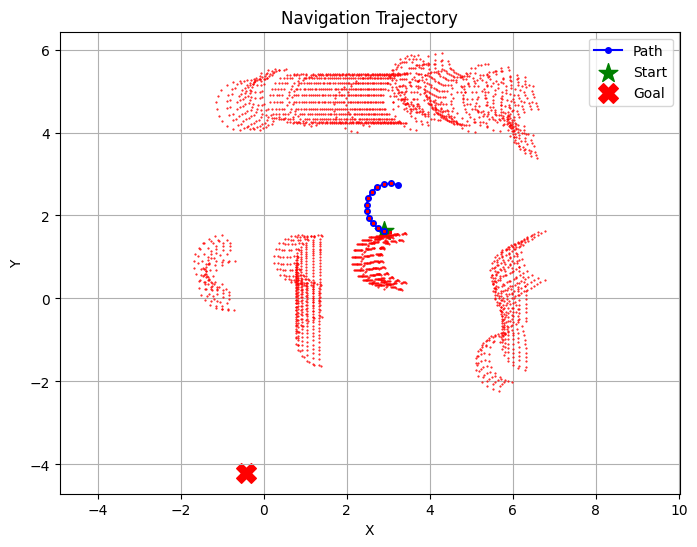

KeyboardInterrupt: 

In [78]:
net = NavigationNet()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(10000):
    # Generate batch using PhiFlow
    initial_pos, goal_pos = generate_batch(512, min_distance=0.3, max_distance=10.0)

    optimizer.zero_grad()
    output = physics_loss(net, initial_pos, goal_pos)
    loss = output[0] if isinstance(output, tuple) else output
    total_loss = loss.sum  # Sum the loss to get a scalar

    # Skip backward and step if loss is NaN/Inf
    if not torch.isfinite(total_loss):
        print(f"Epoch {epoch}: Loss is NaN/Inf, skipping update.")
        continue

    total_loss.backward()  # Backpropagate

    # Clip gradients to prevent explosion (adjust max_norm as needed)
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

    # Check for NaNs in gradients
    has_nan = False
    for p in net.parameters():
        if p.grad is not None and not torch.all(torch.isfinite(p.grad)):
            has_nan = True
            break

    if has_nan:
        print(f"Epoch {epoch}: NaN detected in gradients, skipping step.")
        optimizer.zero_grad()  # Clear gradients to prevent contamination
    else:
        optimizer.step()  # Update parameters if no NaNs

    # Logging and plotting
    if epoch % 500 == 0:
        with torch.no_grad():
            initial_pos, goal_pos = generate_batch(1, 4)
            initial_torch = initial_pos.native("samples,vector").squeeze(0)
            goal_torch = goal_pos.native("samples,vector").squeeze(0)

            loss = physics_loss(net, initial_pos, goal_pos)
            print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

            plot_trajectory(net, initial_torch, goal_torch)

In [63]:
with torch.no_grad():
    initial_torch = torch.tensor([4.5, -3.2], dtype=torch.float32)
    goal_torch = torch.tensor([2.1, -6.1], dtype=torch.float32)

    loss = physics_loss(net, initial_pos, goal_pos)
    # print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

    plot_trajectory(net, initial_torch, goal_torch, 60)

tensor([ 4.5000, -3.2000]) tensor([ 2.1000, -6.1000])


AttributeError: 'Tensor' object has no attribute 'native'

In [79]:
net = torch.load('nav_model.pth')

/var/folders/zf/94x0k5092zgfxzfr4p5680gc0000gn/T/ipykernel_78957/3046724949.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load('nav_model.pth')


/var/folders/zf/94x0k5092zgfxzfr4p5680gc0000gn/T/ipykernel_95024/382003188.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn2 = torch.load('nav_model.pth')


In [12]:
nn2

NavigationNet(
  (control_net): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=2, bias=True)
    (11): Tanh()
  )
)

In [292]:
import numpy as np
import matplotlib.pyplot as plt

def adjust_direction(lidar_points, proposed_displacement, n):
    """
    Adjust the proposed (linear, angular) displacement to avoid obstacles.

    Args:
        lidar_points: (batch, 360) array of obstacle distances.
                      A reading of 0 means no obstacle.
        proposed_displacement: (batch, 2) array [linear, angular] displacement.
        n: safety margin in degrees (±n around the proposed angle).

    Returns:
        Adjusted displacement as a (batch, 2) array.
        For a batch element with no safe candidate, the linear velocity is set to 0.
    """
    batch_size = lidar_points.shape[0]
    # Ensure proposed angles are in [0,360)
    L = proposed_displacement[:, 0]
    theta = proposed_displacement[:, 1] % 360  
    abs_L = np.abs(L)
    if L < 0:
        theta = (theta + 180) % 360

    # --- Step 1: Check the safety of the proposed angle ---
    # Use the rounded (integer) angle for indexing.
    theta_round = np.round(theta).astype(int) % 360
    window_offsets = np.arange(-n, n + 1)
    indices = (theta_round[:, None] + window_offsets) % 360  # shape: (batch, 2n+1)
    # Extract the lidar readings from the safety window.
    readings = np.take_along_axis(lidar_points, indices, axis=1)
    # A reading is dangerous if it is > 0 and is less than or equal to the displacement.
    danger = (readings > 0) & (readings <= 1.5*abs_L[:, None])
    is_proposed_safe = ~danger.any(axis=1)

    # print("is_prozposed_safe: ", is_proposed_safe, theta_round)

    # Prepare outputs.
    new_L = L.copy()
    new_theta = theta.copy()

    # --- Step 2: For unsafe cases, search for a safe alternative ---
    unsafe = np.where(~is_proposed_safe)[0]
    if unsafe.size > 0:
        # Precompute candidate angles and their safety windows.
        candidate_angles = np.arange(360)
        candidate_windows = (candidate_angles[:, None] + window_offsets) % 360  # shape: (360, 2n+1)
        
        for i in unsafe:
            lidar_row = lidar_points[i]  # (360,)
            # For every candidate angle, get its window's readings.
            candidate_readings = lidar_row[candidate_windows]  # shape: (360, 2n+1)
            # Candidate is safe if none of the readings in its window are dangerous.
            candidate_safe = ~((candidate_readings > 0) & (candidate_readings <= 1.5*abs_L[i])).any(axis=1)
            
            if not candidate_safe.any():
                # No safe candidate found: cancel motion.
                new_L[i] = new_L[i]/2
                print("no path found")
            else:
                # Compute circular difference between candidate angles and proposed angle.
                diff = np.abs(candidate_angles - theta[i])
                diff = np.minimum(diff, 360 - diff)
                # Penalize unsafe candidates.
                diff[~candidate_safe] = 360  
                best_angle = candidate_angles[np.argmin(diff)]
                new_theta[i] = best_angle %360

    print("new theta", new_theta, "prev theta", theta)
    if new_L < 0:
        new_theta = (new_theta - 180) % 360
    return np.stack([new_L, new_theta %360], axis=1)



In [293]:

# ===== Create Sample Data =====
# We'll create 4 samples (batch size = 4) with 360 lidar readings each.
# A reading of 0 means no obstacle; a positive value indicates an obstacle at that distance.
batch_size = 4
lidar_points = np.zeros((batch_size, 360), dtype=float)
proposed_displacement = np.zeros((batch_size, 2), dtype=float)
n = 2  # safety margin (±5 degrees)

# Sample 0: Proposed direction is safe.
#   L = 5, theta = 90°; no obstacles.
proposed_displacement[0] = [1, 0]
# lidar_points[0] remains all zeros.

# Sample 1: Proposed direction is unsafe, but a safe alternative exists.
#   L = 5, theta = 10°.
proposed_displacement[1] = [5, 10]
# Place an obstacle within the safety window of the proposed angle.
# The safety window for theta=10 (rounded) with n=5 is: [5,6,...,15].
lidar_points[1, 10] = 5  # Obstacle at angle 10 with distance 3 (<5).
lidar_points[1, 9] = 3
lidar_points[1, 8] = 2
lidar_points[1, 6] = 4
lidar_points[1, 11] = 4
lidar_points[1, 12] = 4
lidar_points[1, 13] = 4
lidar_points[1, 14] = 4


# Sample 2: No safe alternative exists.
#   L = 5, theta = 200°.
proposed_displacement[2] = [5, 200]
# Fill the entire lidar row with obstacles (distance=3).
lidar_points[2, :] = 3

# lidar_points[2, 20:25] = 0

# Sample 3: Proposed direction is unsafe.
#   L = 5, theta = 350°.
proposed_displacement[3] = [5, 350]
# Safety window for theta=350 (rounded) with n=5 is [345, ..., 355].
lidar_points[3, 333:360] = 3  # Obstacle at 350 with distance 3.

# Adjust directions.
adjusted = adjust_direction(lidar_points, proposed_displacement, n)

# ===== Plotting Code =====
# We will create a polar plot for each sample showing:
#   - The lidar readings as points.
#   - The proposed displacement vector.
#   - The adjusted (safe) displacement vector.
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 10))
axes = axes.flatten()

for i in range(batch_size):
    ax = axes[i]
    # Plot the lidar readings.
    # Lidar indices represent angles in degrees. We convert them to radians.
    angles_deg = np.arange(360)
    angles_rad = np.deg2rad(angles_deg)
    # Use the lidar distance as radius.
    # We plot only nonzero obstacles as red dots.
    safe_readings = lidar_points[i] > 0
    ax.scatter(angles_rad[safe_readings], lidar_points[i][safe_readings], 
               c='red', s=20, label='Obstacle')
    
    # Plot the proposed displacement vector.
    # The vector originates at 0 and extends out to length L in the proposed angle.
    prop_angle_rad = np.deg2rad(proposed_displacement[i, 1] % 360)
    ax.arrow(prop_angle_rad, 0, 0, proposed_displacement[i, 0],
             color='blue', width=0.1, label='Proposed', alpha=0.8,
             length_includes_head=True)
    
    # Plot the adjusted displacement vector.
    adj_angle_rad = np.deg2rad(adjusted[i, 1] % 360)
    ax.arrow(adj_angle_rad, 0, 0, adjusted[i, 0],
             color='green', width=0.1, label='Adjusted', alpha=0.8,
             length_includes_head=True)
    
    # Set title for this subplot.
    ax.set_title(f"Sample {i}\nProposed: {proposed_displacement[i]}  Adjusted: {adjusted[i]}")
    ax.set_rmax(6)
    ax.grid(True)
    # Only show legend in one subplot.
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [294]:
import numpy as np
import cv2

def get_lidar_points(binary_img, current_pos, world_limits, num_rays=360, max_range=4.0):
    """
    Get LiDAR first contact points in world coordinates using vectorized operations
    Args:
        binary_img: Binary image where 0 is obstacle, 1 is free space
        current_pos: (x,y) position of the sensor in world coordinates
        world_limits: Array of [[min_x, max_x], [min_y, max_y]] world boundaries
        num_rays: Number of rays to cast (default 360 for 1-degree resolution)
        max_range: Maximum range of the sensor in world units
    Returns:
        points: Array of shape (360,2) with (x,y) coordinates relative to sensor position,
               zeros for rays that don't hit anything
    """
    height, width = binary_img.shape
    # Calculate transformation factors from world to image
    world_width = world_limits[0][1] - world_limits[0][0]
    world_height = world_limits[1][1] - world_limits[1][0]
    scale_x = width / world_width
    scale_y = height / world_height
    # Convert world position to image coordinates
    img_x = int((current_pos[0] - world_limits[0][0]) * scale_x)
    img_y = height - int((current_pos[1] - world_limits[1][0]) * scale_y)
    # Convert max_range to pixels
    max_range_px = int(max_range * min(scale_x, scale_y))
    # Generate all angles at once
    angles = np.linspace(0, 2*np.pi, num_rays, endpoint=False)
    # Generate direction vectors for all angles
    directions = np.stack([np.cos(angles), -np.sin(angles)], axis=0)  # Shape: (2, num_rays)
    # Generate all ray lengths at once
    ray_lengths = np.arange(1, max_range_px)  # Shape: (max_range_px-1,)
    # Calculate all possible points for all rays using broadcasting
    ray_points = (ray_lengths[:, np.newaxis, np.newaxis] * directions[np.newaxis, :, :])
    ray_points = np.transpose(ray_points, (0, 2, 1))  # Reshape to (max_range_px-1, num_rays, 2)
    # Add sensor position to all points
    ray_points_x = ray_points[..., 0] + img_x  # Shape: (max_range_px-1, num_rays)
    ray_points_y = ray_points[..., 1] + img_y
    # Convert to integer coordinates
    ray_points_x = ray_points_x.astype(np.int32)
    ray_points_y = ray_points_y.astype(np.int32)
    # Create masks for valid points
    valid_x = (ray_points_x >= 0) & (ray_points_x < width)
    valid_y = (ray_points_y >= 0) & (ray_points_y < height)
    valid_points = valid_x & valid_y
    # Initialize array to store contact points (replacing the contact_points list)
    contact_points = np.zeros((num_rays, 2))
    lidar_dists = np.ones(num_rays) * np.inf
    # Find first contact points for each ray
    for ray_idx in range(num_rays):
        valid_ray_points = valid_points[:, ray_idx]
        if not np.any(valid_ray_points):
            continue
        ray_x = ray_points_x[valid_ray_points, ray_idx]
        ray_y = ray_points_y[valid_ray_points, ray_idx]
        # Check for obstacles along the ray
        ray_values = binary_img[ray_y, ray_x]
        obstacle_indices = np.where(ray_values == 0)[0]
        if len(obstacle_indices) > 0:
            # Get first contact point
            first_contact_idx = obstacle_indices[0]
            px = ray_x[first_contact_idx]
            py = ray_y[first_contact_idx]
            # Convert back to world coordinates
            world_x = (px / scale_x) + world_limits[0][0]
            world_y = world_limits[1][0] + (height - py) / scale_y
            # Calculate relative coordinates
            rel_x = world_x - current_pos[0]
            rel_y = world_y - current_pos[1]
            dists = np.sqrt(rel_x**2 + rel_y**2)
            # Check if within max range
            if dists <= max_range:
                contact_points[ray_idx] = [rel_x, rel_y]
                lidar_dists[ray_idx] = dists
    return contact_points, lidar_dists

In [295]:
from PIL import Image

In [296]:
image_path = "New_WR_World.png"
img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
binary_img = (img > 128).astype(np.uint8)  # Threshold to create a binary map
binary_img = cv2.resize(binary_img, (0,0), fx=0.25, fy=0.25)

In [297]:
pts, dists = get_lidar_points(binary_img, [4,4], [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)

(-7.0, 7.0)

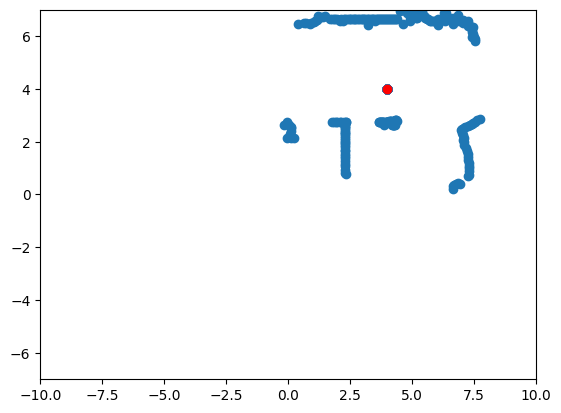

In [298]:
pts+=[np.array([4,4])]
plt.scatter(pts[:, 0], pts[:, 1])
plt.scatter(4, 4, c='red')
plt.xlim(-10, 10)
plt.ylim(-7, 7)

In [299]:
def adjust_actions( lidar_points, proposed_action, world_theta, n, debug=False):
    """
    Adjust the proposed (L, θ) action to avoid collisions and move into the closest free space.
    This function takes the LiDAR scan data (batch, 360) and a proposed action (batch, 2) provided
    in normalized units (both values between -1 and 1). The linear component (L) is interpreted as
    L * max_step_size, and the angular component (θ) is computed as follows:
       1. Convert the robot's current world orientation (world_theta, given in degrees) to radians.
       2. Compute an angular offset by scaling the normalized proposed angular value by π (i.e. ±π radians).
       3. Compute the desired heading as:
              desired_heading (radians) = world_theta (in radians) + (proposed_action[θ] * π)
       4. Convert the desired heading to degrees (in the 0-359 range) for performing LiDAR safety checks.
    If a collision is predicted (using a safety window of ±n deg), the function searches for an alternative,
    and may reduce the linear component if necessary. Finally, the new angular value is converted back
    to a normalized value in [-1,1] (by dividing the found angular displacement (in radians) by π).
    Args:
        lidar_points (np.ndarray): Array of shape (batch, 360) with LiDAR distances.
        proposed_action (np.ndarray): Array of shape (batch, 2) with normalized action values in [-1,1]
                                      for [linear, angular] displacement.
        world_theta (float): The current world orientation of the robot in degrees.
        n (int): Safety margin in degrees for collision checking (±n).
        debug (bool): If True, prints debug statements.
    Returns:
        np.ndarray: Adjusted action of shape (batch, 2) with normalized values in [-1,1].
    """
    if debug:
        print(f"DEBUG: Initial proposed_action: {proposed_action}")
    # If the proposed_action is 1-dimensional, expand its dimensions.
   
    was_single_action = False
    if proposed_action.ndim == 1:
        proposed_action = np.expand_dims(proposed_action, axis=0)
        was_single_action = True
    proposed_action[:, 0] = np.abs([proposed_action[:, 0]])
    # Environment constants.
    max_step_size = 1.0  # Actual maximum displacement (units)
    max_theta = np.pi    # Maximum angular change in radians (i.e. normalized ±1 -> ±π)
    batch_size = proposed_action.shape[0]
    new_action = np.zeros((batch_size, 2))  # initialize the output array
    # Convert the normalized linear action to actual displacement.
    actual_L = np.abs(proposed_action[:, 0]) * max_step_size
    if debug:
        print(f"DEBUG: Computed actual_L: {actual_L}")
    # Convert world_theta (in degrees) to radians.
    world_theta_rad = np.deg2rad(world_theta)
    # Compute the angular offset (in radians) from the normalized proposed action.
    action_theta_offset_rad = proposed_action[:, 1] * max_theta

    if proposed_action[0, 1] < 0:
        action_theta_offset_rad = action_theta_offset_rad - np.pi
    # Desired new heading in radians.
    desired_heading_rad = world_theta_rad + action_theta_offset_rad
    # Convert desired heading to degrees within 0-359.
    actual_theta_deg = np.rad2deg(desired_heading_rad) % 360
    if debug:
        print(f"DEBUG: Computed desired_heading (deg): {actual_theta_deg}")
    # Expand lidar_points to include batch dimension if needed.
    if lidar_points.ndim == 1:
        lidar_points = lidar_points[np.newaxis, :]
    if debug:
        print(f"DEBUG: lidar_points shape after potential expansion: {lidar_points.shape}")
    # Loop over each sample.
    for i in range(batch_size):
        if debug:
            print(f"DEBUG: Processing sample {i}")
        # Define a narrow safety window ±n degrees.
        window_offsets = np.arange(-n, n + 1)
        if debug:
            print(f"DEBUG: window_offsets: {window_offsets}")
        # Round the intended heading (in degrees) to an integer.
        proposal_angle = np.round(actual_theta_deg[i]).astype(int)
        if debug:
            print(f"DEBUG: Sample {i} proposal_angle: {proposal_angle}")
        indices = (proposal_angle + window_offsets) % 360
        if debug:
            print(f"DEBUG: Sample {i} safety window indices: {indices}")
        readings = lidar_points[i, indices]
        if debug:
            print(f"DEBUG: Sample {i} LiDAR readings in safety window: {readings}")
        # If any reading in the window is <= 1.5 * max_step_size, the action is unsafe.
        if (readings <= max_step_size * 1.5).any():
            if debug:
                print(f"DEBUG: Sample {i}: Proposed action is unsafe.")
            candidate_range = np.arange(-n, n+1)
            candidate_angles = (proposal_angle + candidate_range) % 360
            if debug:
                print(f"DEBUG: Sample {i}: candidate_range: {candidate_range}")
                print(f"DEBUG: Sample {i}: candidate_angles: {candidate_angles}")
            best_candidate = None
            best_diff = 360  # Initialize with maximum possible angular difference.
            candidate_safe_distance = 0
            # Evaluate candidate angles within the safety window.
            for cand in candidate_angles:
                cand_indices = (cand + window_offsets) % 360
                cand_readings = lidar_points[i, cand_indices]
                cand_safe_dist = np.min(cand_readings)
                diff_angle = min(abs(cand - actual_theta_deg[i]), 360 - abs(cand - actual_theta_deg[i]))
                if debug:
                    print(f"DEBUG: Sample {i}: Evaluating candidate angle {cand}:")
                    print(f"       cand_indices: {cand_indices}")
                    print(f"       cand_readings: {cand_readings}")
                    print(f"       cand_safe_dist: {cand_safe_dist}, diff_angle: {diff_angle}")
                # Choose candidate if it has enough free space and is closer in angle to the original.
                if (cand_safe_dist > 0 and cand_safe_dist >= (max_step_size - 1e-2)) and diff_angle < best_diff:
                    best_diff = diff_angle
                    best_candidate = cand
                    candidate_safe_distance = cand_safe_dist
                    if debug:
                        print(f"DEBUG: Sample {i}: New best candidate found: {cand} with diff {best_diff} and safe distance {cand_safe_dist}")
            # If no candidate was found, reduce the linear displacement.
            if best_candidate is None:
                new_actual_L = actual_L[i] * 0.5
                new_actual_theta_deg = actual_theta_deg[i]
                if debug:
                    print(f"DEBUG: Sample {i}: No free candidate found; halving L to {new_actual_L}.")
            else:
                new_actual_theta_deg = best_candidate
                margin = 0.9  # Use a safety margin.
                new_actual_L = min(actual_L[i], candidate_safe_distance * margin)
                if debug:
                    print(f"DEBUG: Sample {i}: Candidate angle {best_candidate}° selected with safe distance {candidate_safe_distance}.")
                    print(f"DEBUG: Sample {i}: New linear displacement set to {new_actual_L}.")
            # Normalize the adjusted linear and angular actions.
            new_action[i, 0] = np.clip(new_actual_L / max_step_size, -1, 1)
            new_theta_rad = np.deg2rad(new_actual_theta_deg)
            new_action[i, 1] = np.clip(new_theta_rad / max_theta, -1, 1)
            if debug:
                print(f"DEBUG: Sample {i}: Updated action: linear = {new_action[i, 0]}, angular (normalized) = {new_action[i, 1]}")
        elif (readings <= max_step_size * 3).any():
            new_action[i, 0] = actual_L[i] / 2
            if debug:
                print(f"DEBUG: Sample {i}: Proposed action is safe but L is halved to {new_action[i, 0]}")
        else:
            # If no adjustments are needed, pass the proposed normalized action.
            new_action[i, 0] = proposed_action[i, 0]
            new_action[i, 1] = proposed_action[i, 1]
            if debug:
                print(f"DEBUG: Sample {i}: Proposed action is safe, no adjustments made.")
    if was_single_action:
        if debug:
            print(f"DEBUG: Returning single action: {new_action[0]}")
        return new_action[0]
    if debug:
        print(f"DEBUG: Returning batch of actions: {new_action}")
        print("DEBUG: Exiting adjust_actions")
    new_action[:, 1] = np.abs(new_action[:, 1])
    return new_action

In [300]:
import matplotlib.pyplot as plt
import torch

def plot_trajectory(net, initial_pos, goal_pos, max_steps=12):
    """Simulate and plot a single trajectory using PyTorch tensors"""
    with torch.no_grad():
        current_pos = initial_pos.clone()
        goal_pos = goal_pos.clone()

        print(current_pos, goal_pos)
        
        theta = torch.zeros_like(current_pos[0])
        positions = []
        lidar_pts = []
        
        for stp in range(max_steps):
            delta_pos = goal_pos - current_pos
            relative_theta = torch.atan2(delta_pos[1], delta_pos[0]) - theta

            relative_theta = (relative_theta + np.pi) % (2 * np.pi) - np.pi

            pts, dists = get_lidar_points(binary_img, current_pos.numpy(), [(-10, 10),(-8, 8)], num_rays=360, max_range=5.0)
            # print(dists)
            lidar_pts.append(pts+current_pos.numpy())
            
            net_input = torch.stack([
                current_pos[0]/8, current_pos[1]/6,
                goal_pos[0]/8, goal_pos[1]/6,
                theta/math.PI, relative_theta/math.PI
            ], dim=-1).unsqueeze(0)
            
            controls = net(net_input)[0]
            L = controls[0]
            delta_theta = controls[1]*math.PI

            # print(L, delta_theta, theta, torch.clip(delta_theta, -math.PI/9, math.PI/9))
            # controls2 = adjust_actions(dists, controls.numpy(),  np.rad2deg(theta.numpy()), 3,  True)

            # L = controls2[0]
            # delta_theta = controls2[1]*math.PI

            # theta = theta + delta_theta
            # theta = (theta + np.pi) % (2 * np.pi) - np.pi 

            # print(.shape, .shape)
            

            l = adjust_direction(dists[np.newaxis, :], np.array([[L,np.rad2deg(theta)]]), 3)
           


            # print(l)
            
            ad_theta = torch.tensor(np.deg2rad(l[0, 1]))
            # print(theta, ad_theta)

            ad_theta = (ad_theta + np.pi) % (2 * np.pi) - np.pi 

            print(f'adjusted: {np.rad2deg(ad_theta.numpy())- np.rad2deg(theta)}')


            # print("step", stp, " ", np.rad2deg(theta), net_input)
        
            
            # theta += delta_theta
            # movement = torch.stack([
            #     L * torch.cos(theta),
            #     L * torch.sin(theta)
            # ])

            movement = torch.stack([
                L * torch.cos(ad_theta),
                L * torch.sin(ad_theta)
            ])


            
            current_pos += movement
            # Append a copy of the numpy array to avoid reference issues
            positions.append(current_pos.cpu().numpy().copy())  # Fixed line

            # break
            
            if torch.norm(delta_pos) < 0.1:
                break
        
        positions = np.array(positions)
        # Rest of the plotting code remains the same
        plt.figure(figsize=(8, 6))
        plt.imshow(binary_img, extent=[-10, 10, -8, 8], aspect='auto')
        plt.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, label='Path')
        # for pt in lidar_pts:
        #     plt.scatter(pt[:, 0], pt[:, 1])

        # circle_points = np.array([[3 + 1 * np.cos(theta), -2 + 1 * np.sin(theta)] 
        #                   for theta in np.linspace(0, 2*np.pi, 100)])
        # plt.plot(circle_points[:, 0], circle_points[:, 1], 'g-', linewidth=2)

        plt.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='*', label='Start')
        plt.scatter(goal_pos[0].item(), goal_pos[1].item(), c='red', s=200, marker='X', label='Goal')
        plt.title("Navigation Trajectory")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.xlim(-10, 10)
        plt.ylim(-8, 8)
        plt.axis('equal')
        plt.legend()
        plt.show()


tensor([ 5.2000, -2.0000]) tensor([-1., -2.])
new theta [180.] prev theta [180.]
adjusted: 0.0
new theta [180.] prev theta [180.]
adjusted: 0.0
new theta [134.] prev theta [180.]
adjusted: -46.000022888183594
new theta [353.] prev theta [0.]
adjusted: -7.000028133392334
new theta [358.] prev theta [0.]
adjusted: -2.000002145767212
new theta [0.] prev theta [0.]
adjusted: 0.0
new theta [29.] prev theta [0.]
adjusted: 28.999998092651367
new theta [79.] prev theta [0.]
adjusted: 79.0
new theta [72.] prev theta [0.]
adjusted: 71.99998474121094
new theta [85.] prev theta [0.]
adjusted: 84.99999237060547
new theta [281.] prev theta [0.]
adjusted: -79.0
new theta [98.] prev theta [0.]
adjusted: 98.0
new theta [278.] prev theta [0.]
adjusted: -81.99998474121094
new theta [98.] prev theta [0.]
adjusted: 98.0
new theta [278.] prev theta [0.]
adjusted: -81.99998474121094
new theta [98.] prev theta [0.]
adjusted: 98.0
new theta [278.] prev theta [0.]
adjusted: -81.99998474121094
new theta [98.] pr

/var/folders/zf/94x0k5092zgfxzfr4p5680gc0000gn/T/ipykernel_78957/2213468446.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  l = adjust_direction(dists[np.newaxis, :], np.array([[L,np.rad2deg(theta)]]), 3)
/var/folders/zf/94x0k5092zgfxzfr4p5680gc0000gn/T/ipykernel_78957/2213468446.py:59: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f'adjusted: {np.rad2deg(ad_theta.numpy())- np.rad2deg(theta)}')


new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [99.] prev theta [0.]
adjusted: 98.99999237060547
new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [99.] prev theta [0.]
adjusted: 98.99999237060547
new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [99.] prev theta [0.]
adjusted: 98.99999237060547
new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [99.] prev theta [0.]
adjusted: 98.99999237060547
new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [99.] prev theta [0.]
adjusted: 98.99999237060547
new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [99.] prev theta [0.]
adjusted: 98.99999237060547
new theta [279.] prev theta [0.]
adjusted: -80.99998474121094
new theta [98.] prev theta [0.]
adjusted: 98.0
new theta [278.] prev theta [0.]
adjusted: -81.99998474121094
new theta [98.] prev theta [0.]
adjusted: 98.0
new theta [278.] prev theta [0.]
adjusted: -81.999

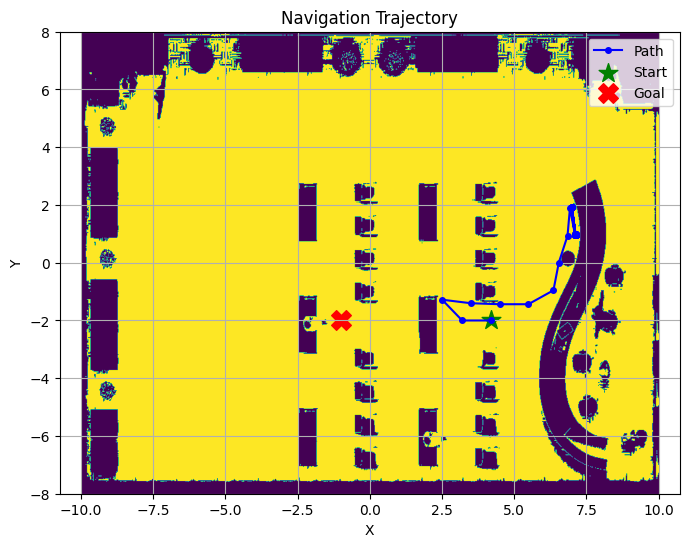

In [301]:
with torch.no_grad():
    initial_torch = torch.tensor([5.2, -2], dtype=torch.float32)
    goal_torch = torch.tensor([-1, -2], dtype=torch.float32)

    loss = physics_loss(net, initial_pos, goal_pos)
    # print(f"Epoch {epoch}, Loss: {loss.native().item():.4f}")

    plot_trajectory(net, initial_torch, goal_torch, 60)

In [246]:
np.array([[1,3]]).shape

(1, 2)